In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import matplotlib.dates as mdates
import seaborn as sns
# from sklearn.cluster import KMeans

In [2]:
user = "aabounak"
password = "mysecretpassword"
host = "localhost"
port = "5433"
database = "piscineds"

def connect_to_postgres():
  return create_engine(
    url=f"postgresql://{user}:{password}@{host}:{port}/{database}"
  )

In [3]:
engine = connect_to_postgres()

In [4]:
with engine.connect() as connection:
  result = connection.execute(text('select * from customers *'))
  data = result.fetchall()

columns_names = result.keys()
df = pd.DataFrame(data, columns=columns_names)
df.head()

,event_time,event_type,product_id,price,user_id,user_session,category_id,category_code,brand
0,2022-12-20 09:04:38+00:00,cart,5714948,5.56,445560136,198d995b-7422-430e-b0d4-a0a84f803ac0,NaN,None,None
1,2022-12-20 09:04:38+00:00,remove_from_cart,5863524,8.56,589736577,85453dd6-a250-46a7-aea0-ecf1e00aa0ce,NaN,None,None
2,2022-12-20 09:05:11+00:00,remove_from_cart,5878210,1.27,564639980,8a785479-9049-424d-8af5-a6c2fb5f37cf,NaN,None,None
3,2022-12-20 09:05:12+00:00,cart,5854897,0.32,475297298,e24add73-20ac-4aed-bf6e-269d71c93480,1.487580e+18,None,None
4,2022-12-20 09:05:12+00:00,view,5866301,3.73,561062844,20cae03f-5773-4814-95b0-35eff5114117,NaN,None,None


In [5]:

df.to_csv(r'./\selected_data.csv')

In [6]:
sns.set_style("darkgrid")

### Exercise 00

<AxesSubplot: ylabel='event_type'>

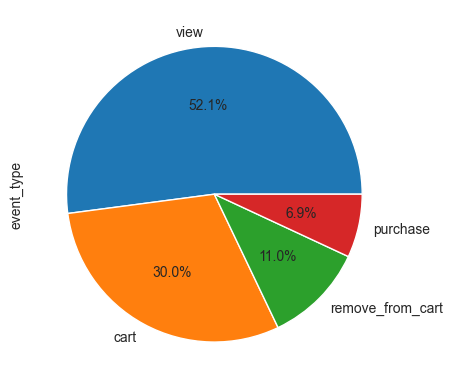

In [7]:
df['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

### Exercise 01

In [20]:
df['event_time'] = pd.to_datetime(df['event_time'])
purchase_data = df[(df['event_type'] == 'purchase')]

In [23]:
purchase_data = purchase_data.copy()

In [26]:
purchase_data['year'] = purchase_data['event_time'].dt.year
purchase_data.loc[:, 'month'] = purchase_data['event_time'].dt.month
purchase_data.loc[:, 'day'] = purchase_data['event_time'].dt.day

<AxesSubplot: xlabel='Date', ylabel='Number of customers'>

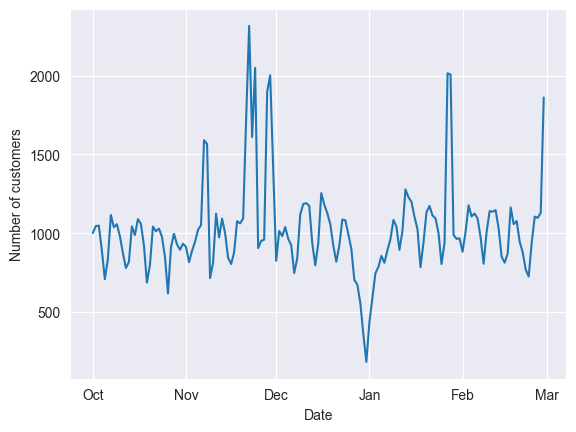

In [27]:
daily_customer_counts = purchase_data.groupby(['year', 'month', 'day'])['user_id'].nunique().reset_index()
daily_customer_counts['date'] = pd.to_datetime(daily_customer_counts[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

plt.ylabel('Number of customers')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sns.lineplot(data=daily_customer_counts, x='date', y='user_id')

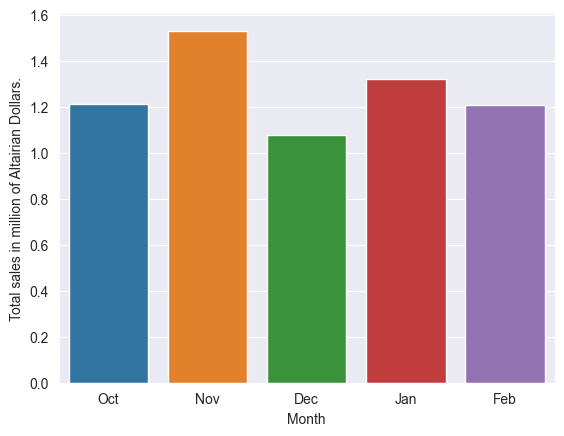

In [28]:
total_sales = purchase_data.groupby(['year', 'month'])['price'].sum().reset_index()
total_sales['date'] = pd.to_datetime(total_sales[['year', 'month']].astype(str).agg('-'.join, axis=1)).dt.strftime('%b')

total_sales['price_in_million'] = total_sales['price'] / 1000000

sns.barplot(data=total_sales, x='date', y='price_in_million')

plt.xlabel('Month')
plt.ylabel('Total sales in million of Altairian Dollars.')
plt.show()

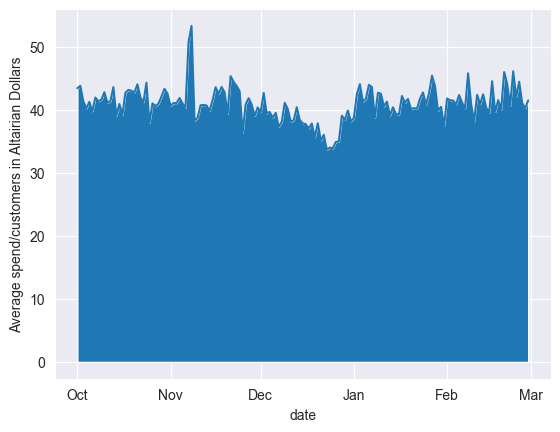

In [29]:
total_sales = purchase_data.groupby(['year', 'month', 'day'])['price'].sum().reset_index()
merged_data = pd.merge(total_sales, daily_customer_counts, on=['year', 'month', 'day'])
merged_data['average_spend_per_customer'] = merged_data['price'] / merged_data['user_id']
merged_data['date'] = pd.to_datetime(merged_data[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

sns.lineplot(data=merged_data, x='date', y='average_spend_per_customer')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.fill_between(merged_data['date'], merged_data['average_spend_per_customer'])
plt.ylabel('Average spend/customers in Altairian Dollars')
plt.show()


### Ex02

count    1.285199e+06
mean     4.933983e+00
std      8.929314e+00
min     -7.937000e+01
25%      1.590000e+00
50%      3.000000e+00
75%      5.400000e+00
max      3.277800e+02
Name: price, dtype: float64


<AxesSubplot: xlabel='price'>

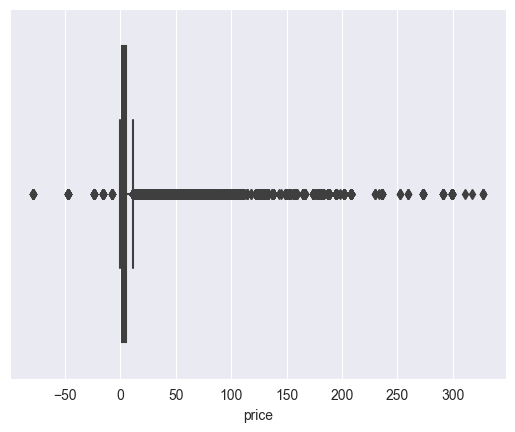

In [32]:
transformed_purchase_data = purchase_data.copy()
transformed_purchase_data['price'] = transformed_purchase_data['price'].astype(float)

print(transformed_purchase_data['price'].describe())
sns.boxplot(data=transformed_purchase_data, x='price')

<AxesSubplot: xlabel='price'>

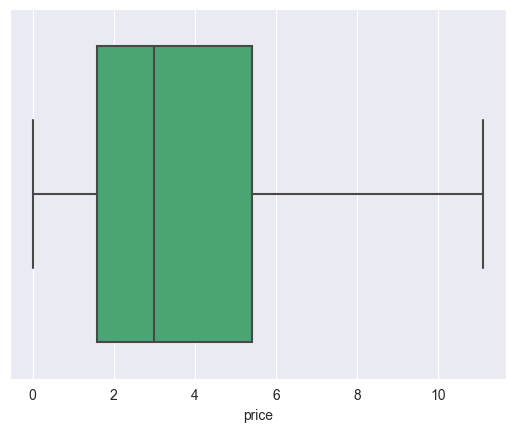

In [33]:
sns.boxplot(data=transformed_purchase_data, x='price', showfliers=False, color='mediumseagreen')

In [35]:
cart_df = df[(df['event_type'] == 'cart')]
cart_df = cart_df.copy()

In [34]:
# avg_basket = cart_df.groupby('user_id')['price'].mean().reset_index(name='avg_basket_price')
# avg_basket.head(10)
# sns.boxplot(data=avg_basket, x='avg_basket_price', showfliers=False)

,user_id,avg_basket_price
0,2963072,6.555714
1,4103071,0.670000
2,4661182,19.370000
3,5493470,3.586000
4,6217356,6.825000
5,8194617,5.560000
6,8846226,3.646250
7,9794320,5.593750
8,10079204,12.905000
9,10120387,0.000000


### Ex03

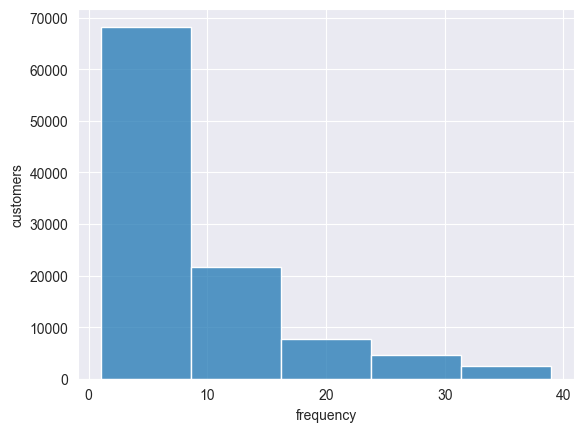

In [123]:
grouped_data = purchase_data.groupby('user_id').size().reset_index(name='purchases')
result = grouped_data[grouped_data['purchases'] < 40].sort_values(by='purchases', ascending=False)

ax = sns.histplot(data=result, x='purchases', bins=5)
ax.set(xlabel='frequency', ylabel='customers')
ax.set_xticks([0, 10, 20, 30, 40])
plt.show()

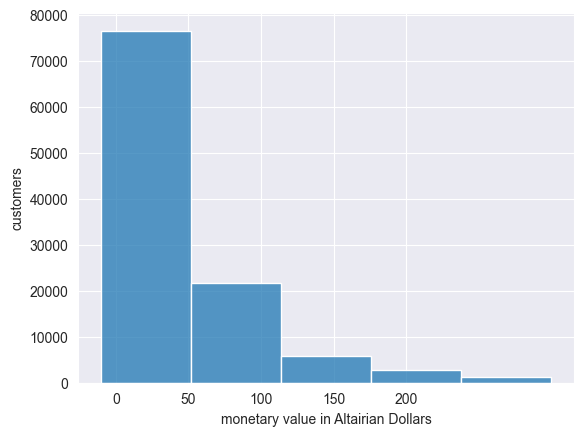

In [124]:
grouped_data = purchase_data.groupby('user_id')['price'].sum().reset_index(name='purchases')
monetary = grouped_data[grouped_data['purchases'] < 300].sort_values(by='purchases')

ax = sns.histplot(data=monetary, x='purchases', bins=5)
ax.set(xlabel='monetary value in Altairian Dollars', ylabel='customers')
ax.set_xticks([0, 50, 100, 150, 200])
plt.show()

### Ex04
